**Imports**

In [95]:
from shiftNMF_frozen import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *

In [96]:

def plotSpaced(ax,x,y):
    ymax = y.max()
    yoffset = ymax
    for i in range(y.shape[1]):
        ax.plot(x,y[:,i]+yoffset*i)

    ax.set_yticks([])

def change_violin_colors(violin_parts, color_list):
    for pc, linecolor in zip(violin_parts["bodies"], color_list):
        pc.set_facecolor(linecolor)
        pc.set_alpha(1)


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'black' if w > 0 else 'white'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

N, M, d = 15, 15000, 5
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V.real


np.random.seed(42)

W = np.random.dirichlet(np.ones(d), N)
W_unique = W
W_unique = np.append(W_unique, [[1,0,0,0,0]], axis=0)
W_unique = np.append(W_unique, [[0,1,0,0,0]], axis=0)
W_unique = np.append(W_unique, [[0,0,1,0,0]], axis=0)
W_unique = np.append(W_unique, [[0,0,0,1,0]], axis=0)
W_unique = np.append(W_unique, [[0,0,0,0,1]], axis=0)
shift = 100
tau_small = np.random.randint(-shift, shift, size=(N, d))
tau_small_unique = np.random.randint(-shift, shift, size=(N+5, d))
tau_small[W==0] = 0
tau_small_unique[W_unique==0] = 0
shift = 600
tau_big = np.random.randint(-shift, shift, size=(N, d))
tau_big[W==0] = 0
multiplets = 5
J_coupling = np.random.randint(500, 1000, size=(d))
#evenly space out means
mean = np.linspace(2500, M-2500, multiplets)
std = [np.random.randint(70, 200) for _ in range(multiplets)]
t = np.arange(0, M, 1)
# mults = np.random.randint(1,6 , size=(5))
mults = [2,3,1,2,5]

Text(0.5, 1.0, 'H True')

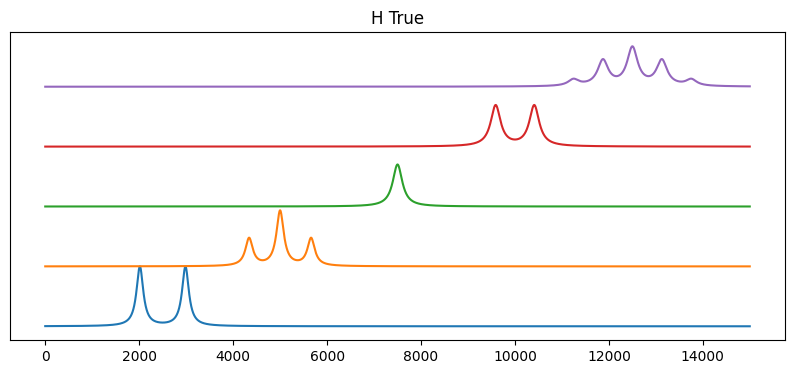

In [97]:

H = np.array([multiplet(t, mult, m, s, j) for m, s, mult,j in list(zip(mean, std, mults, J_coupling))])

# Plot H and H_est
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot()
plotSpaced(ax1, np.arange(H.shape[1]), H.T)
ax1.set_title('H True')

# Experiment 1 low shift and no unique mixings

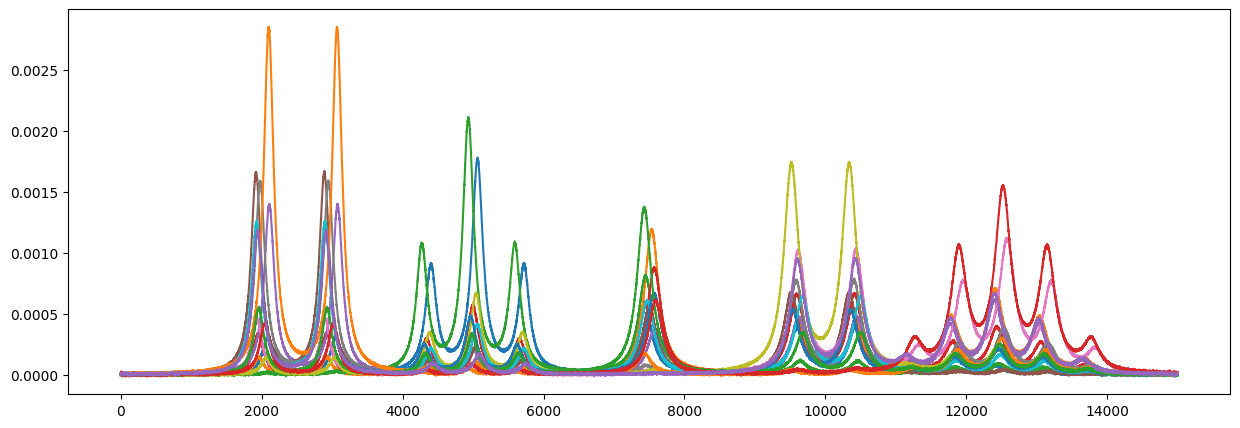

In [98]:


X = shift_dataset(W, H, tau_small)

noise = np.random.normal(0, 5e-6, X.shape)
# noise = np.abs(noise)
X_noisy = X + noise

plt.figure(figsize=(15, 5))
plt.plot(X_noisy.T)
plt.show()

**Fit NMF and extract components**

epoch: 3000, Loss: 0.015428443706546663, Tau: 5580.3688946161975


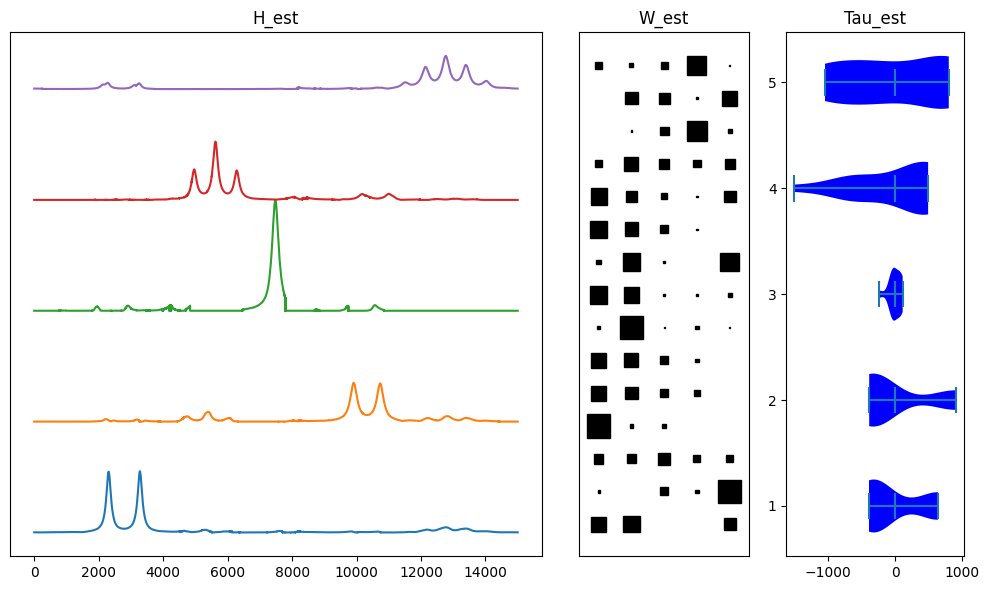

In [99]:
nmf = ShiftNMF(X, 5, lr=0.1, alpha=1e-6, patience=1000, min_imp=0)
W_est,H_est,tau_est, running_loss_hybrid = nmf.fit(verbose=True, return_loss=True, max_iter=3000, tau_iter=0, Lambda=0)



# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(10, 6))

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'H estimated')

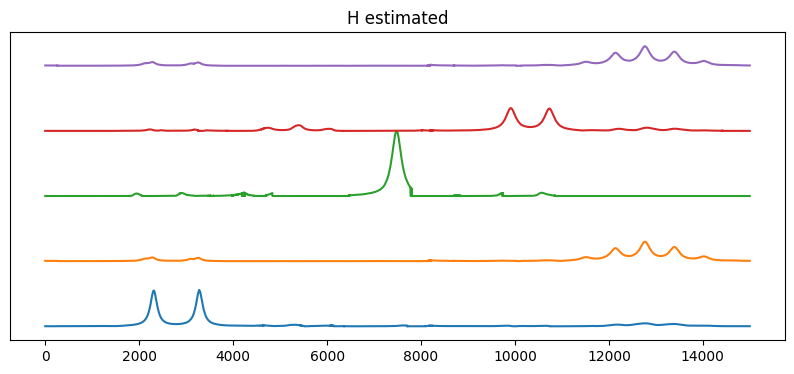

In [101]:
# Plot H and H_est
myorder = [0,4,2,1,4]
H_est = np.array([H_est[i] for i in myorder])
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot()
plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H estimated')

# Experiment 2 low shift, unique components present

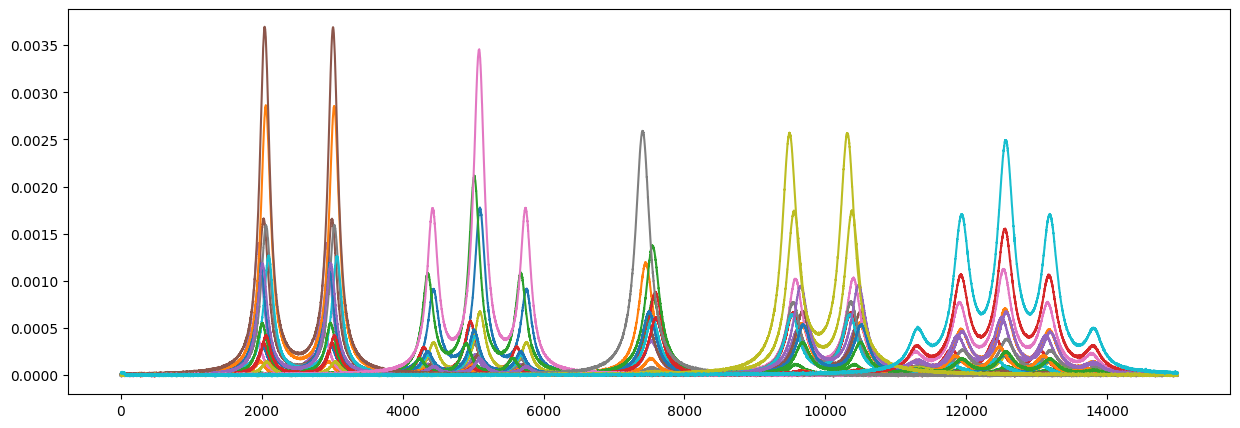

In [102]:


X = shift_dataset(W_unique, H, tau_small_unique)

noise = np.random.normal(0, 5e-6, X.shape)
# noise = np.abs(noise)
X_noisy = X + noise

plt.figure(figsize=(15, 5))
plt.plot(X_noisy.T)
plt.show()

epoch: 3000, Loss: 0.01752983101134313, Tau: 6912.76088115305815


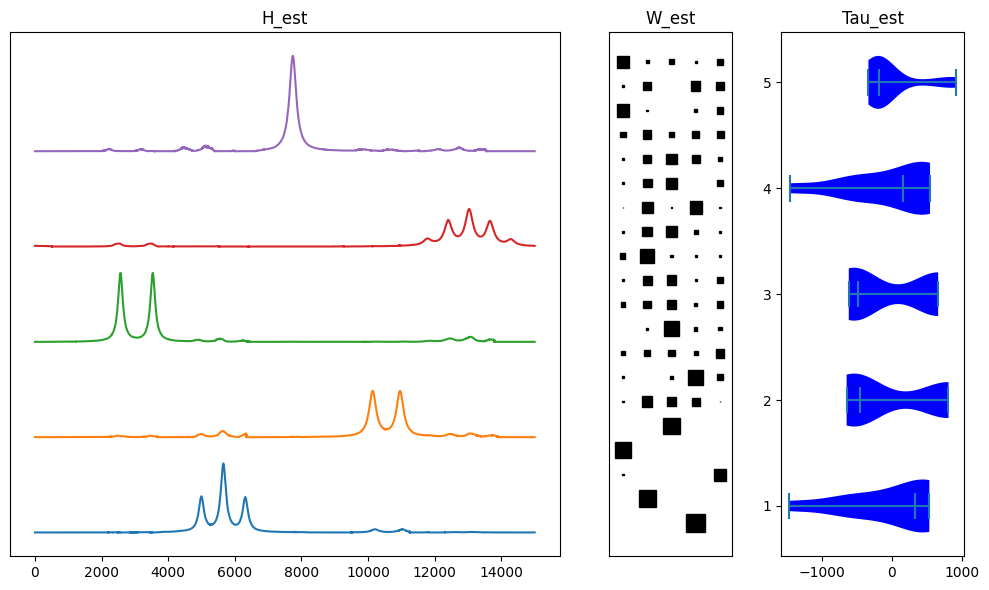

In [103]:
nmf = ShiftNMF(X, 5, lr=0.1, alpha=1e-6, patience=1000, min_imp=0)
W_est,H_est,tau_est, running_loss_hybrid = nmf.fit(verbose=True, return_loss=True, max_iter=3000, tau_iter=0, Lambda=0)



# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(10, 6))

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=False, showmedians=True, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# Experiment 3 larger shift no unique

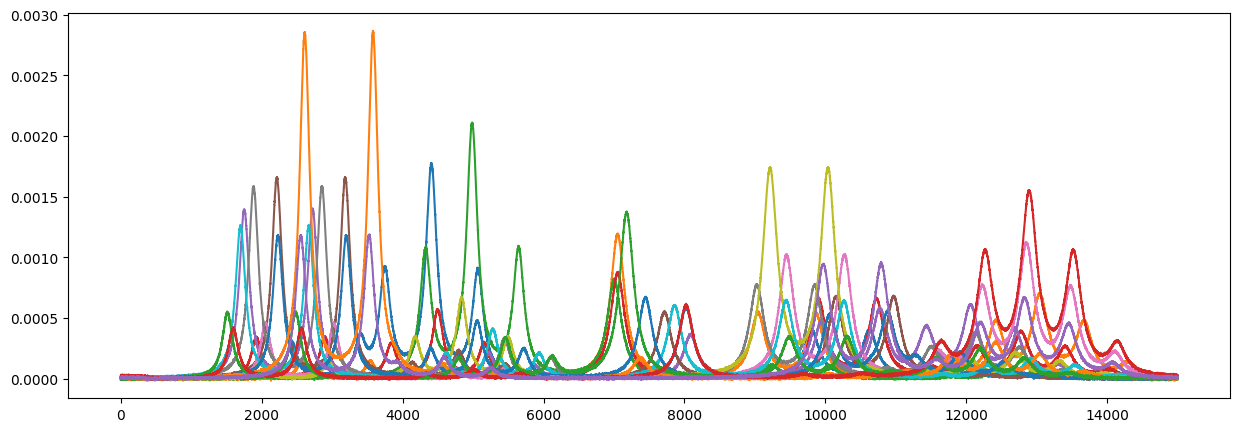

In [93]:

X = shift_dataset(W, H, tau_big)

noise = np.random.normal(0, 5e-6, X.shape)
# noise = np.abs(noise)
X_noisy = X + noise

plt.figure(figsize=(15, 5))
plt.plot(X_noisy.T)
plt.show()

epoch: 1500, Loss: 0.029181321810336433, Tau: 5810.8570796398025


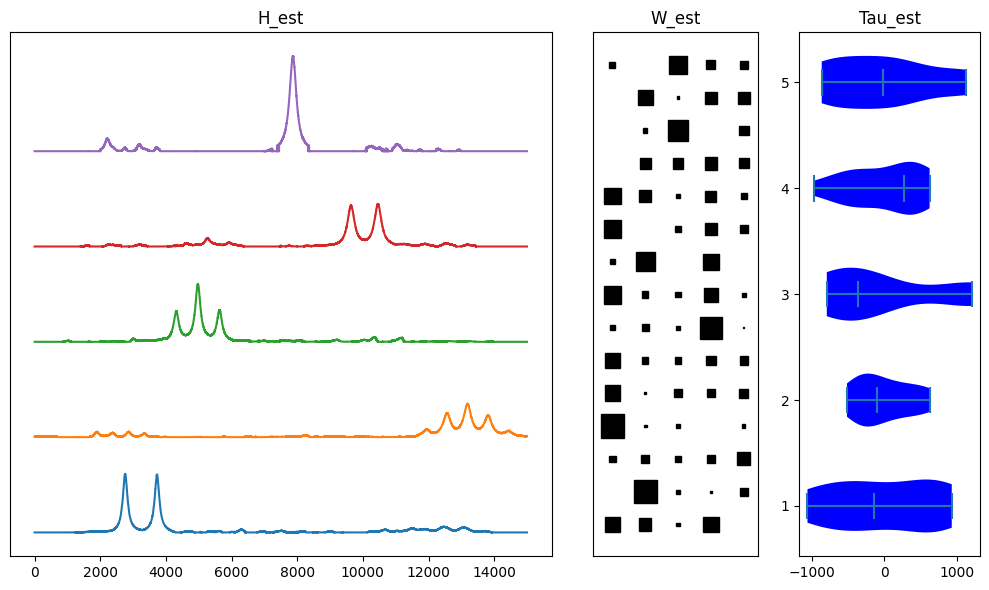

In [94]:
nmf = ShiftNMF(X_noisy, 5, lr=0.1, alpha=1e-6, patience=1000, min_imp=0)
W_est,H_est,tau_est, running_loss_hybrid = nmf.fit(verbose=True, return_loss=True, max_iter=1500, tau_iter=0, Lambda=0)



# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(10, 6))

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=False, showmedians=True, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()